In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import decoupler as dc
import sys
sys.path.append('/Users/ef6/Documents/GitHub/metalinks_analysis/scripts')
from aux import *
from scipy.stats import fisher_exact
import statsmodels.stats.multitest as multi
from pypath.utils import mapping


In [9]:
# load interactions
df = pd.read_csv('/Users/ef6/Documents/GitHub/metalinks_analysis/metalinksDB/MR_Kidney_Urine_noSTITCH.csv')
df['MetName'] = df['metabolite'].str.replace('"', '')
df['HMDB'] = df['HMDB'].str.replace('"', '')
df['Symbol'] = df['Symbol'].str.replace('"', '')
df['LR'] = df['MetName'] + '_' + df['Symbol']
df.drop_duplicates(subset='LR', inplace=True)

In [10]:
# load additional metabolite pathways
mapping = pd.read_excel('/Users/ef6/Documents/GitHub/metalinks-benchmark/scripts/MetabolomicsData_Hakimi/Input_MetabolomicsResults/Supplementarytable2_mmc2.xlsx', sheet_name='S2', skiprows=4)
mapping.dropna(subset=['HMDB'], inplace=True)
# add '00' after the first 4 characters
mapping['HMDB'] = mapping['HMDB'].astype(str)
mapping['HMDB'] = mapping['HMDB'].apply(lambda x: x[:4] + '00' + x[4:] if len(x) > 4 else x)
mapping.index = mapping['HMDB']
mapping.rename(columns={'Unnamed: 9': 'Pathway_sorted'}, inplace=True)
mapping = mapping[['Pathway_sorted']]

# add to df
df = df.join(mapping, on='HMDB', how='left', lsuffix='_df', rsuffix='_additional')

In [11]:
# Load statisic from COSMOS
RNA = pd.read_csv('/Users/ef6/Documents/Saez/metalinks/Data/Intermediate/COSMOS/RNA_ttop_tumorvshealthy.csv', index_col=0)
RNA_IDS = pd.read_csv('/Users/ef6/Documents/Saez/metalinks/Data/Intermediate/Mapping/COSMOS_RNA.csv', index_col=1)
RNA = RNA.join(RNA_IDS, how='left')
RNA.rename(columns={'SYMBOL': 'Symbol'}, inplace=True)
RNA.index = RNA['Symbol']
RNA = RNA.iloc[:,0:6]


MET = pd.read_csv('/Users/ef6/Documents/Saez/metalinks/Data/Intermediate/COSMOS/metab_ttop_tumour_vs_healthy.csv', index_col=0)
COSMOS_mapping = pd.read_csv('/Users/ef6/Documents/Saez/metalinks/Data/Intermediate/Mapping/ocean_mets.csv', index_col=0)
metabolites = MET.join(COSMOS_mapping, how='left')
metabolites.index = metabolites['HMDB']
MET = metabolites.iloc[:,0:6]

In [12]:
res_df = df.join(MET, on='HMDB', how='inner')
res_df = res_df.join(RNA, on='Symbol', how='inner', lsuffix='_met', rsuffix='_rna')
res_df['metalinks'] = (res_df['t_met'] + res_df['t_rna']) / 2
# produce a score that takes the absolute values of t_met and t_rna 
res_df['metalinks_absolute'] = (res_df['t_met'].abs() + res_df['t_rna'].abs()) / 2
res_df.sort_values(by='metalinks', ascending=False, key = lambda x: np.abs(x), inplace=True)

In [131]:
# save the column with highest score from 'a.experiment', 'a.database',
    #    'a.prediction', 'a.textmining'
res_df['highest_score'] = res_df[['a.experiment', 'a.database', 'a.prediction', 'a.textmining']].idxmax(axis=1)
res_df['highest_score'] = res_df['highest_score'].str.replace('a.', '')
res_df['highest_score'] 


/var/folders/nv/yqjsg18n1tz0n9cys1xtqclm0000gq/T/ipykernel_60878/2946705748.py:3: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  res_df['highest_score'] = res_df[['a.experiment', 'a.database', 'a.prediction', 'a.textmining']].idxmax(axis=1)


4203     textmining
2075     textmining
2074     prediction
5251     textmining
3118     textmining
            ...    
13793    textmining
451      textmining
10337    textmining
2822     prediction
11442    textmining
Name: highest_score, Length: 951, dtype: object

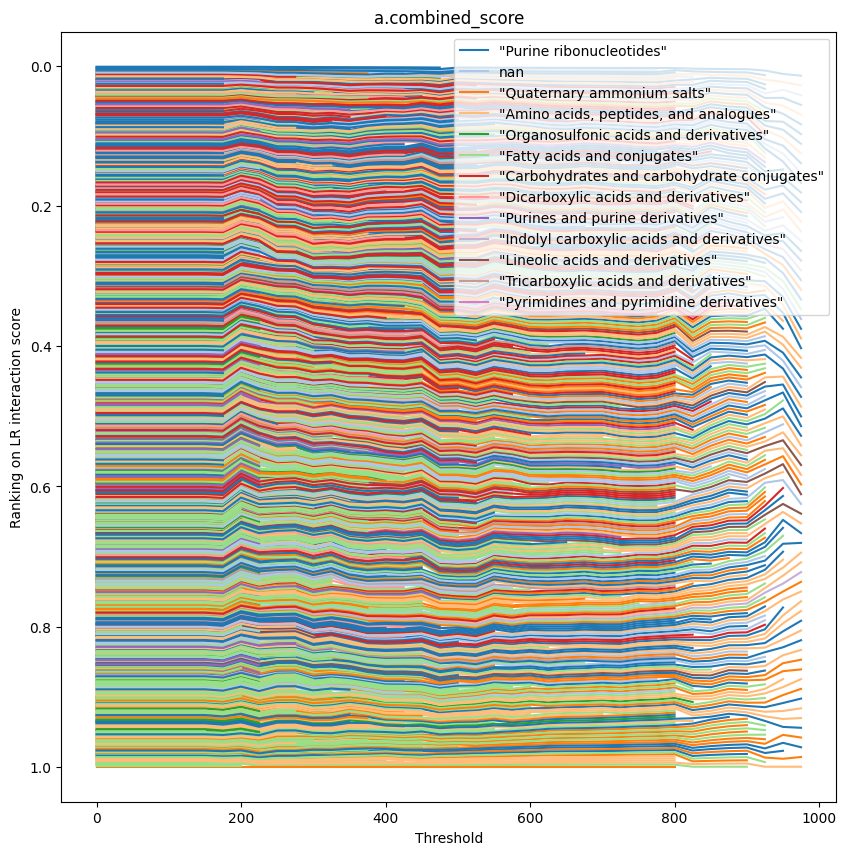

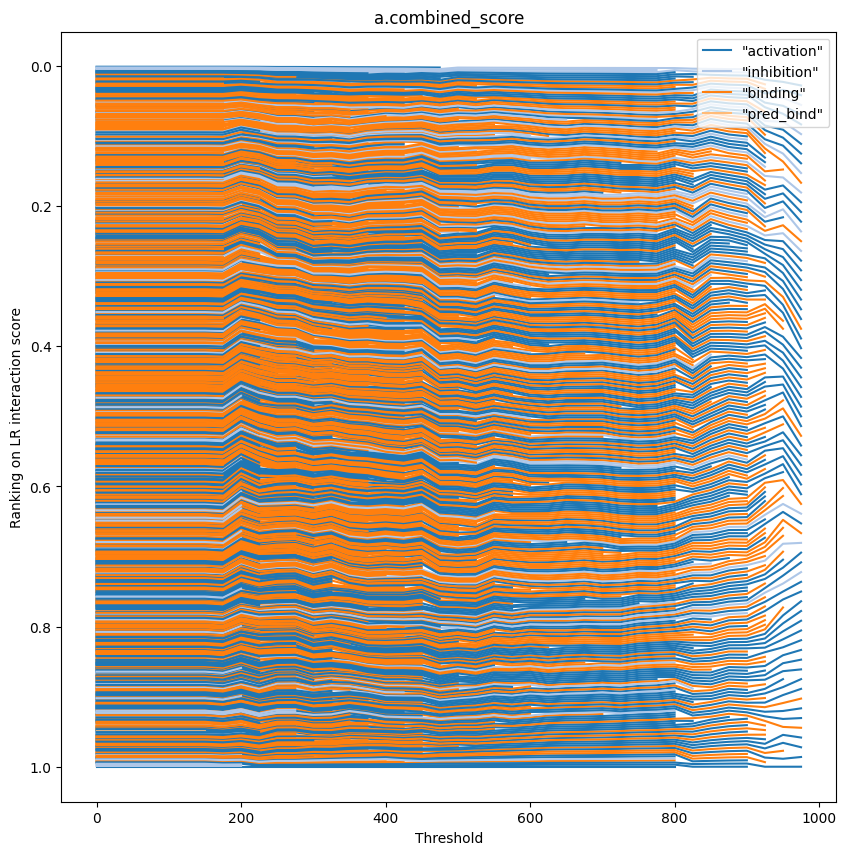

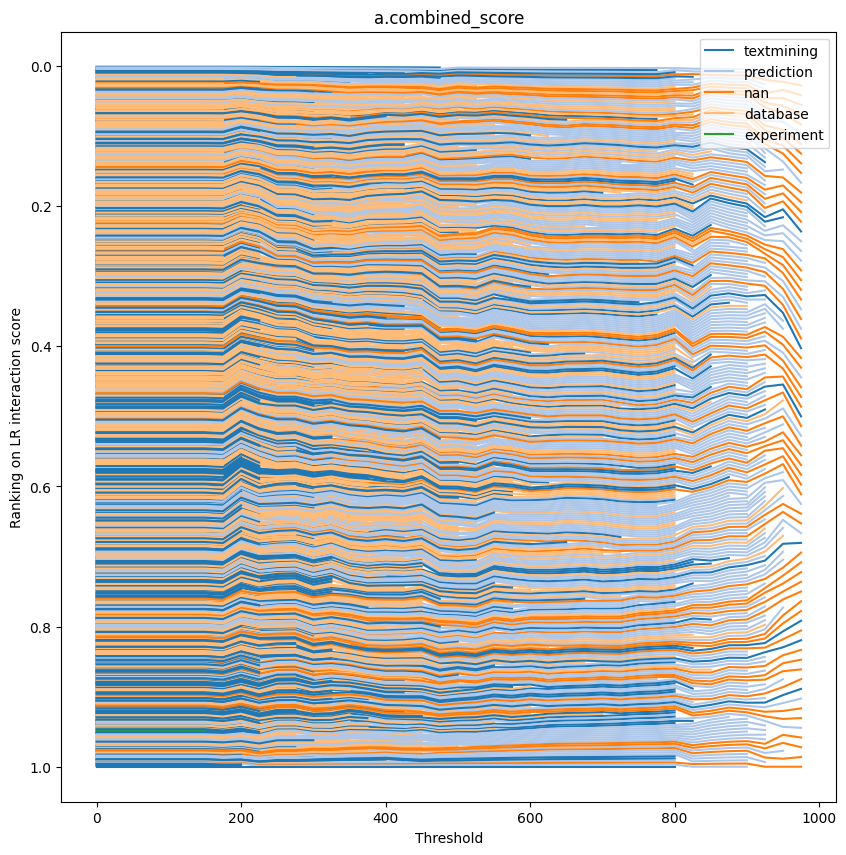

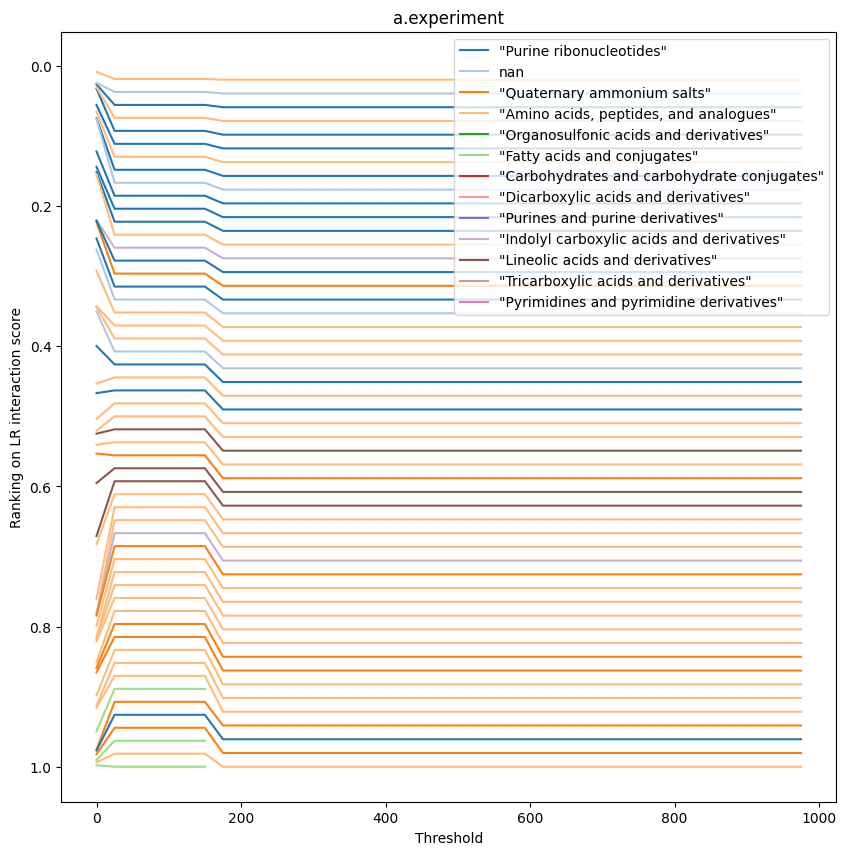

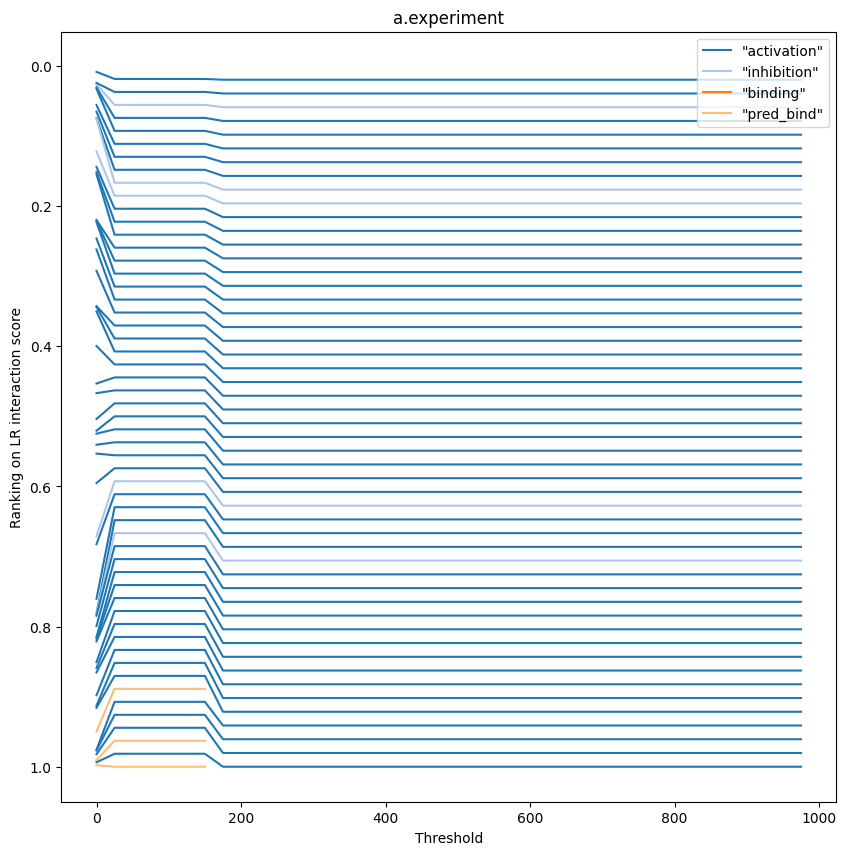

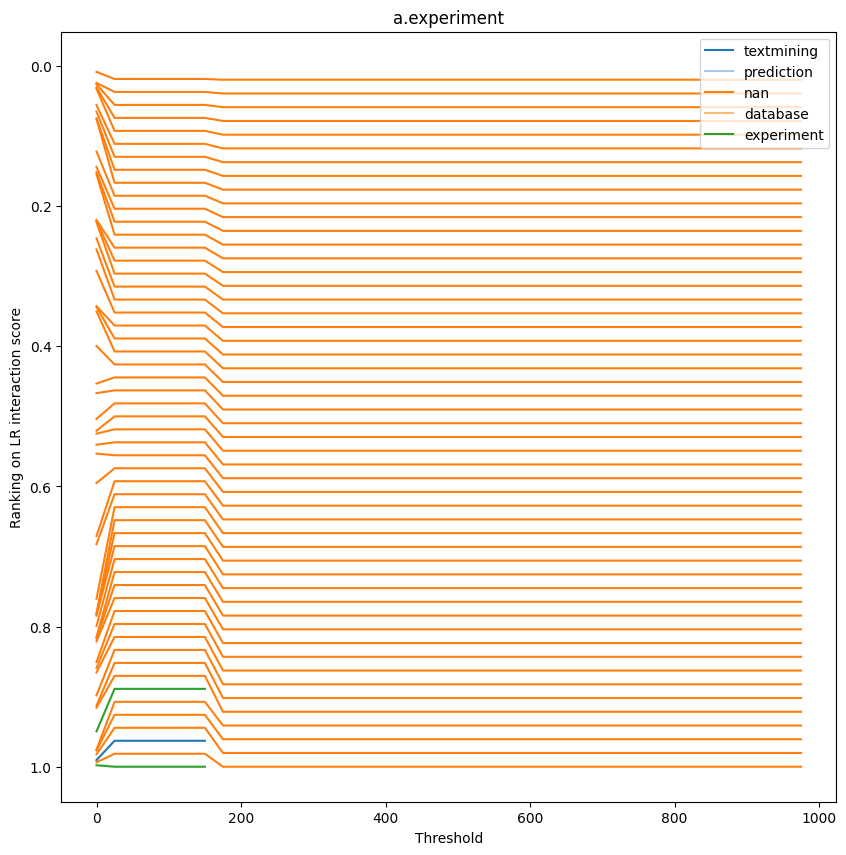

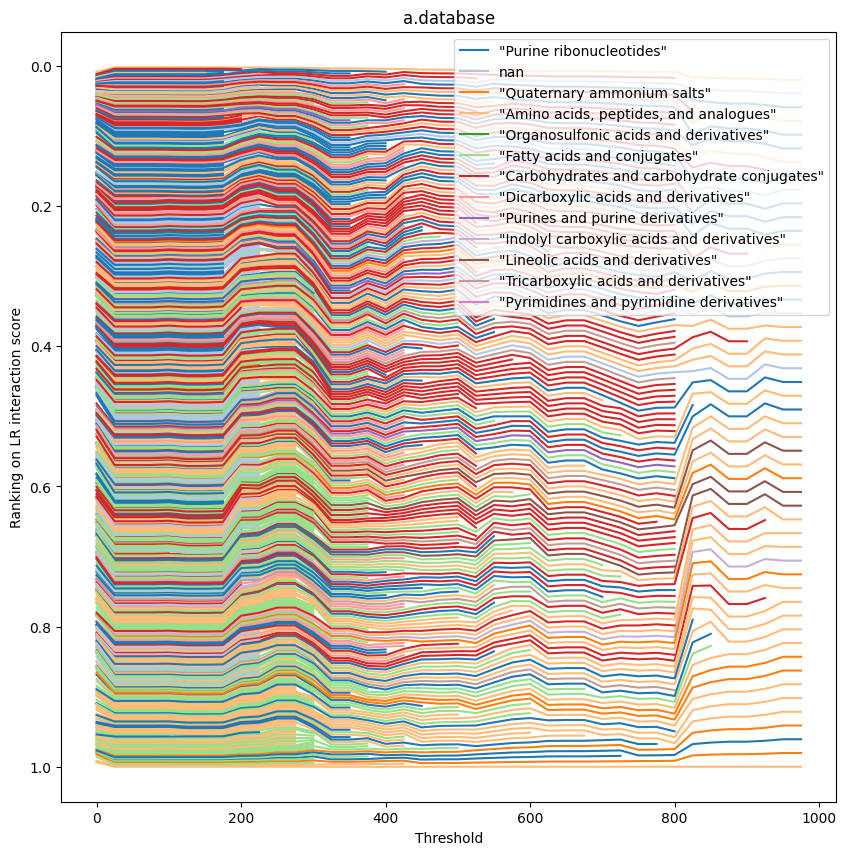

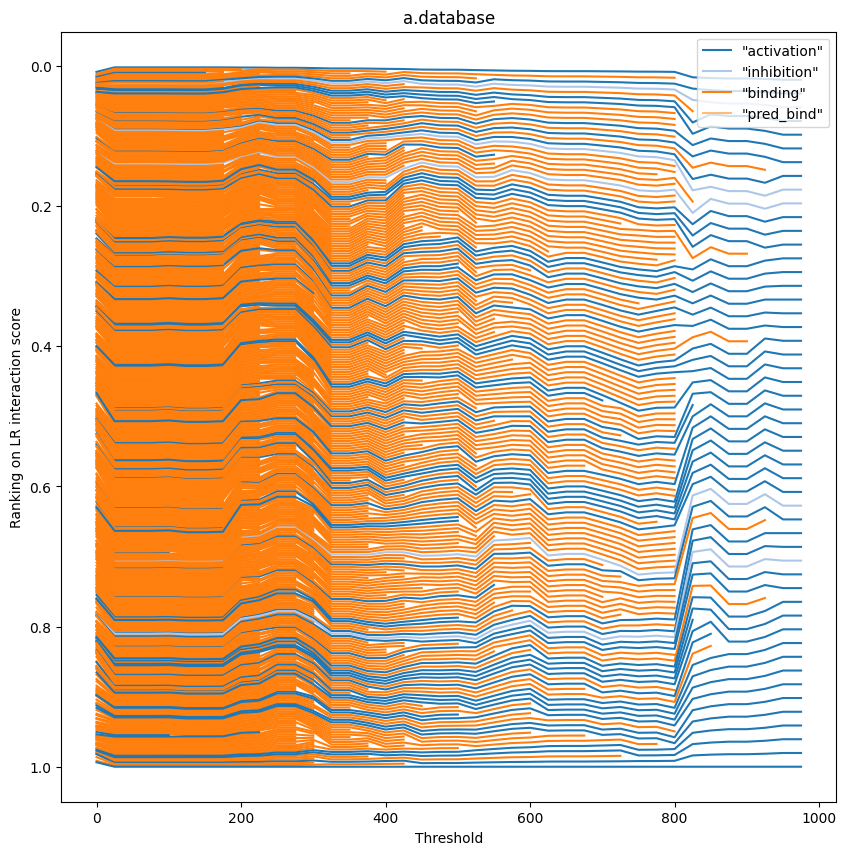

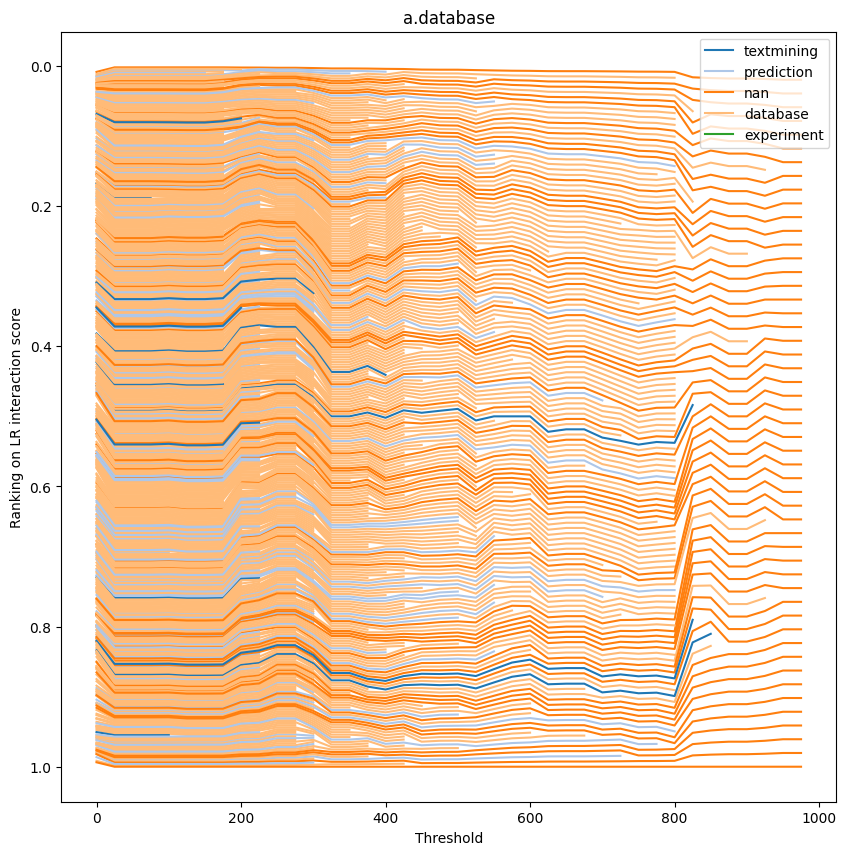

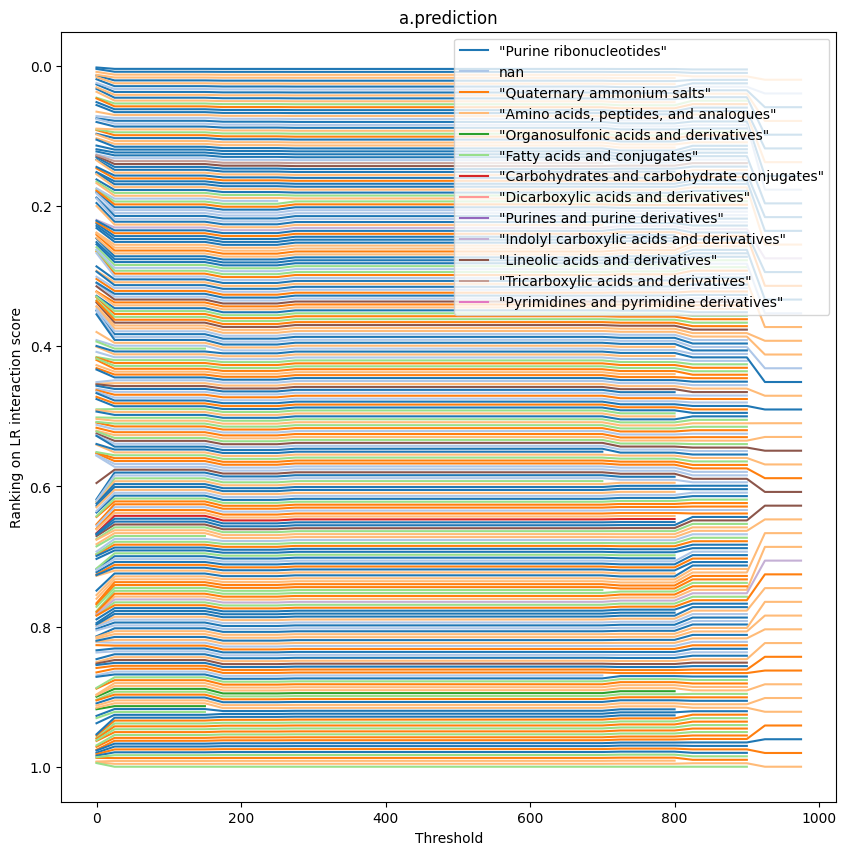

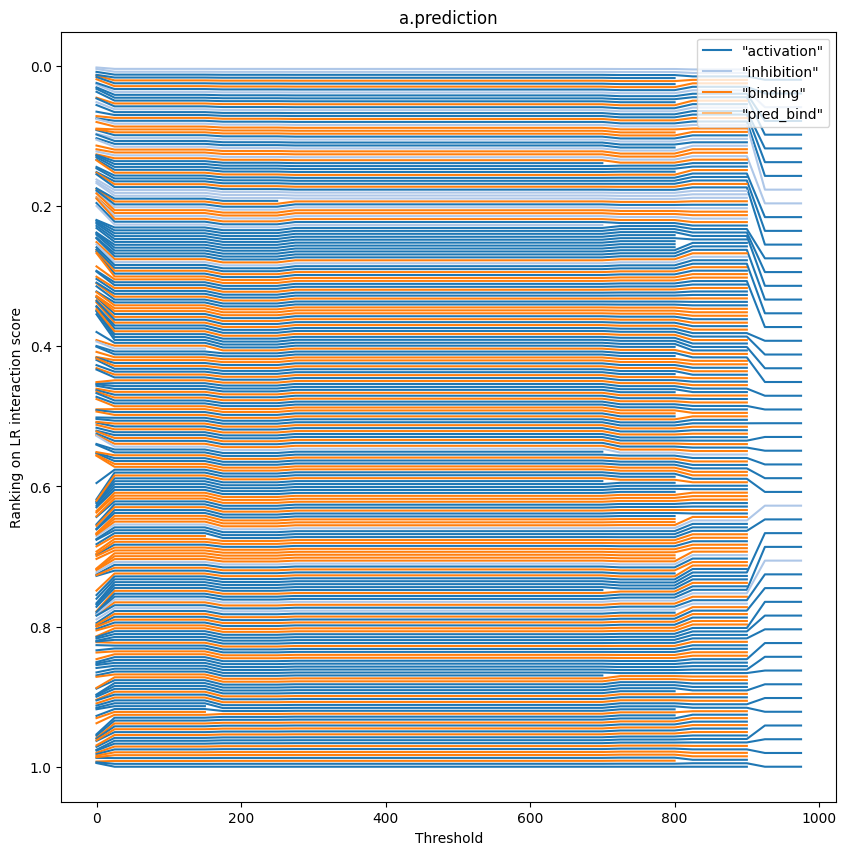

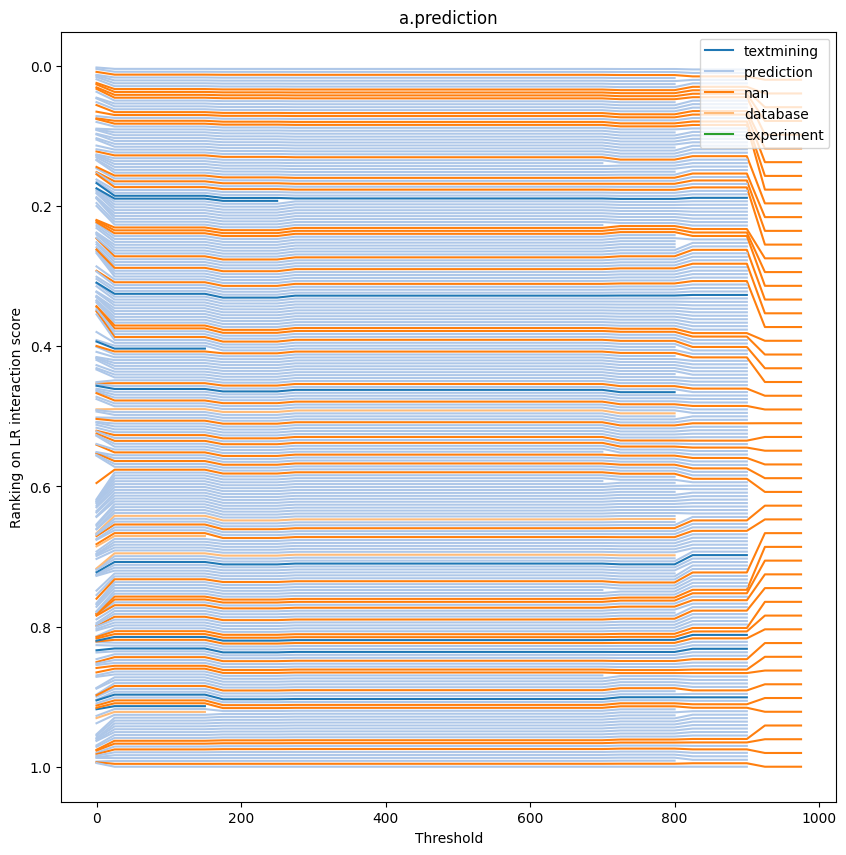

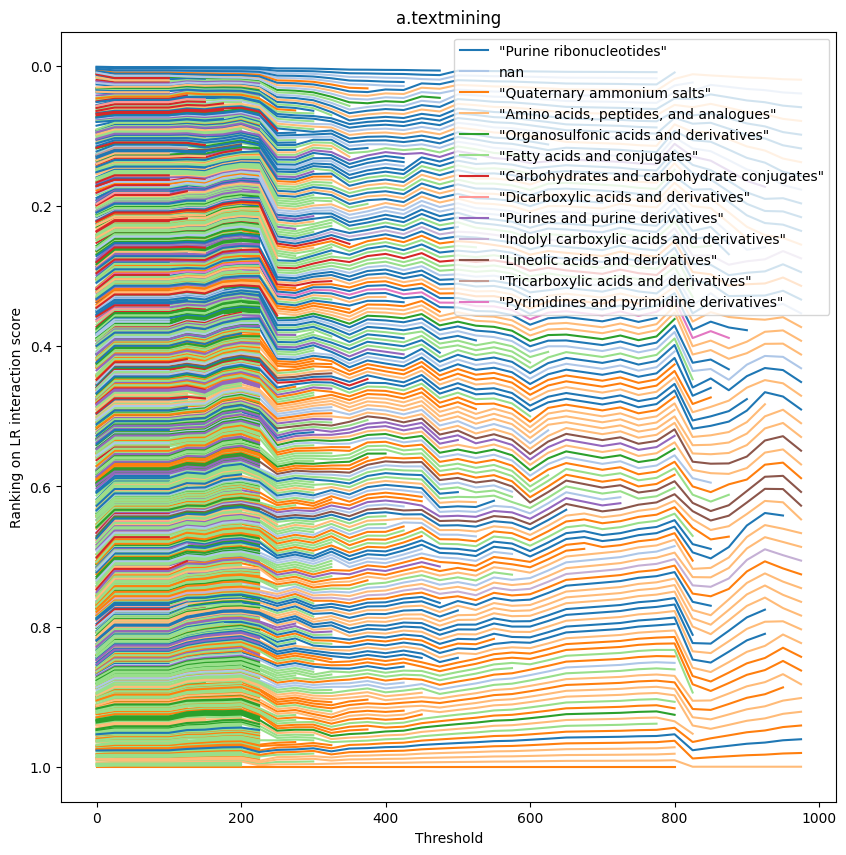

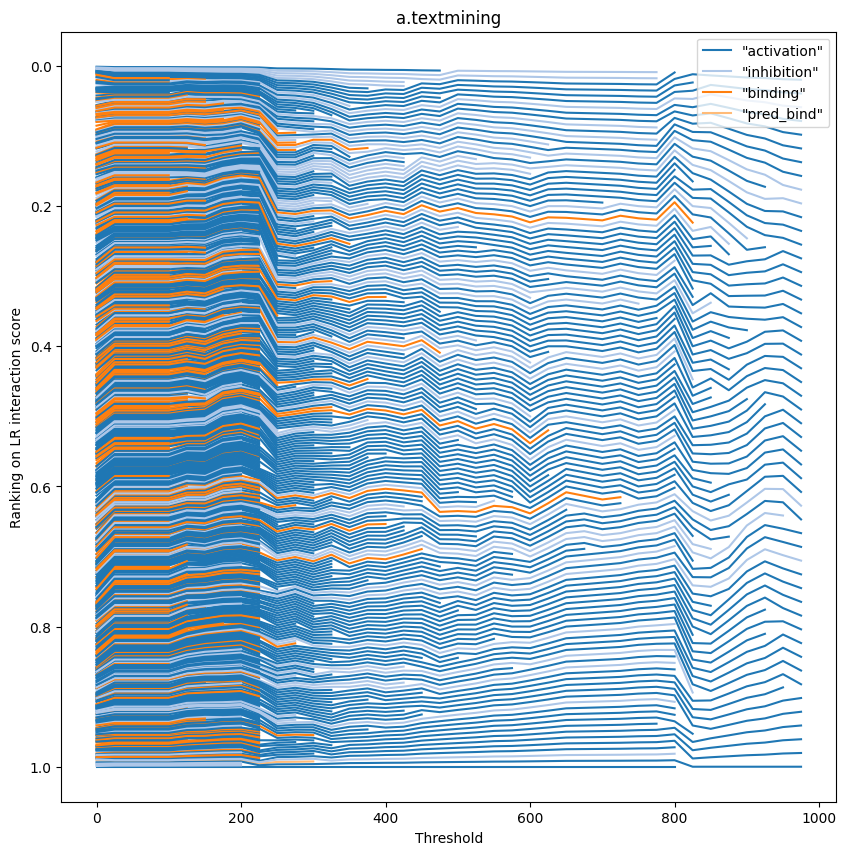

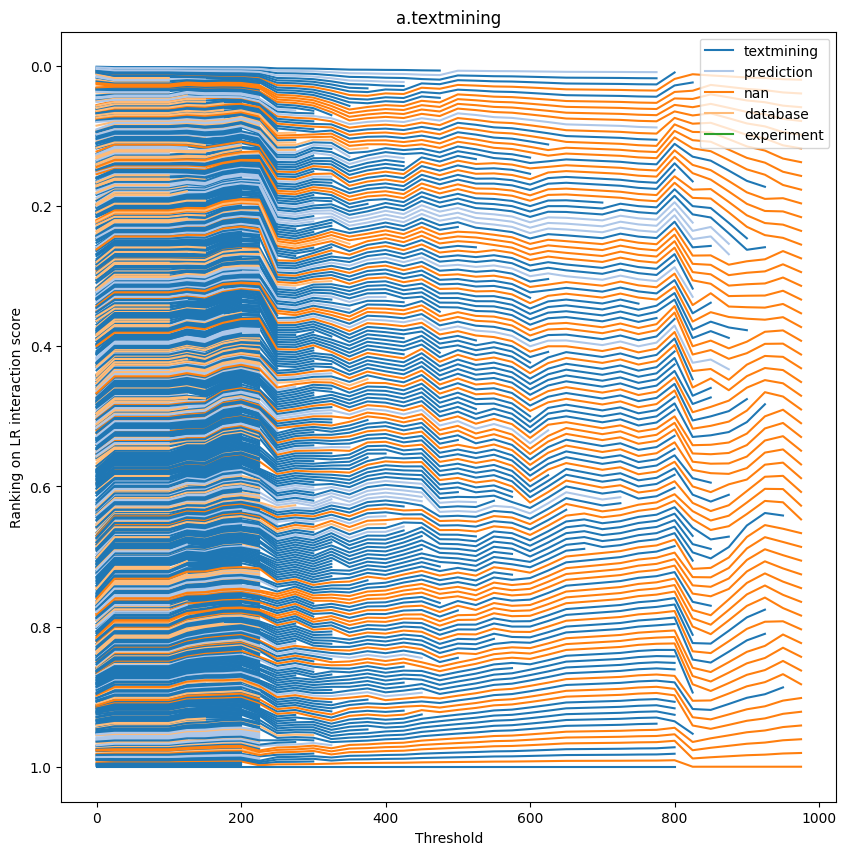

In [152]:



combined_variation = res_df['metalinks_absolute']
combined_variation.index = res_df['LR']
numbers = []
for i in range(0, 1000, 25):
    numbers.append(i)

scores = ['a.combined_score', 'a.experiment', 'a.database',
       'a.prediction', 'a.textmining']

for score in scores:
    # replicate the column of the combined variation 40 times and give test as column names
    rep = pd.concat([combined_variation]*40, axis=1)
    rep.columns = numbers

    for i in range(len(rep.index)):
        counter = 0
        for j in rep.columns:
            if list(res_df[score])[i] < j:
                rep.iloc[i, counter] = np.nan

            counter += 1

    ranked = rep.rank(ascending=False)
    # print(ranked)

    # normalize the ranks by dividind each value by the maximum value in the columns
    ranked = ranked / ranked.max()

    # print(ranked)

    import matplotlib.pyplot as plt
    import seaborn as sns

    for col in ['metabolite_subclass', 'a.mode', 'highest_score']:
        column = col
        # Assuming 'res_df['HMDB']' contains unique labels for each line
        label_color_dict = {}
        unique_labels = res_df[column].unique()
        color_palette = sns.color_palette('tab20', len(unique_labels))

        for label, color in zip(unique_labels, color_palette):
            label_color_dict[label] = color

        plt.figure(figsize=(10, 10))

        for i in range(len(ranked.index)):
            label = res_df[column].iloc[i]
            plt.plot(ranked.columns, ranked.iloc[i, :], label=label, color=label_color_dict[label])
        # invert y axis
        plt.gca().invert_yaxis()
        plt.legend()
        # plot the legend outside the box of the plot
        plt.legend(loc='center right', bbox_to_anchor=(1, 0.5))
        # let the legend only show unique labels
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        plt.legend(by_label.values(), by_label.keys())
        plt.xlabel('Threshold')
        plt.ylabel('Ranking on LR interaction score')
        plt.title(score)
        # plt.tight_layout()
        plt.show()
